In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils 

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


True



## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [5]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.



In [6]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [4]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
    'mesangial cell', #cannot do it... too few cells
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
    'endothelial cell'
]
NUM_GENES = 5000
MAXCELLS = 1024


In [7]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 15728 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leide

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 86/86 [01:11<00:00,  1.20it/s]


base enrichment
Top central genes: []


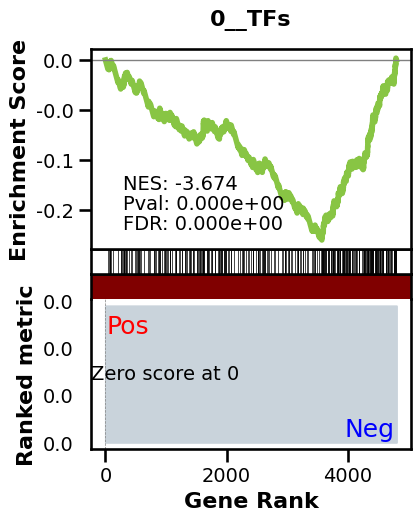

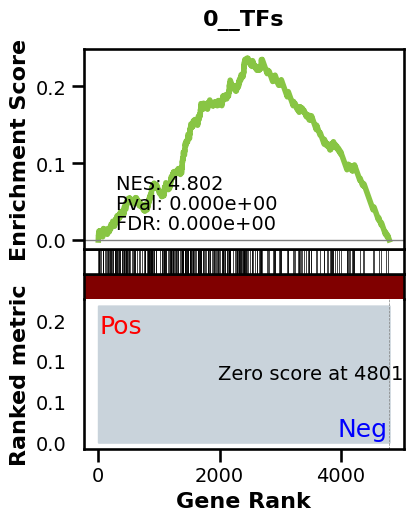

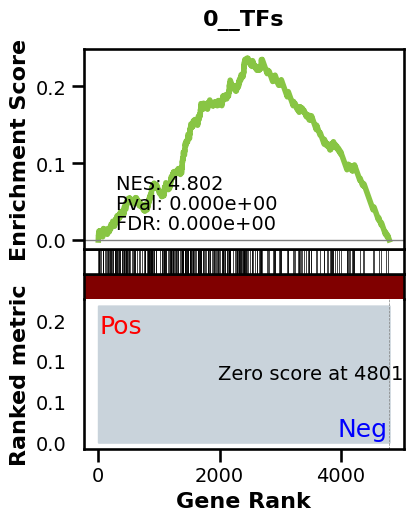

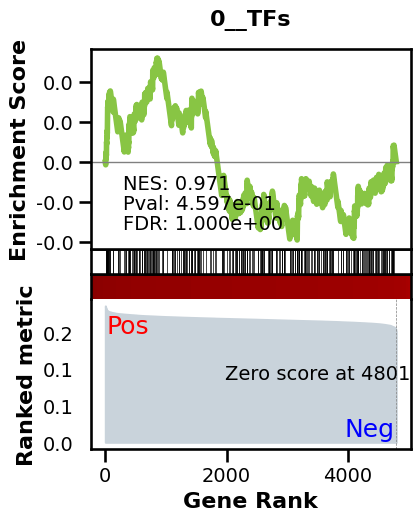

_________________________________________
TF specific enrichment
found some significant results for  9.67741935483871 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3426 genes
intersection pct: 0.7134527280299875
precision:  0.0010854974272151866 
recall:  1.0 
random precision: 0.001085814360770578


100%|██████████| 128/128 [00:02<00:00, 55.85it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0013005673364124525
EPR: 0.7947674432237868


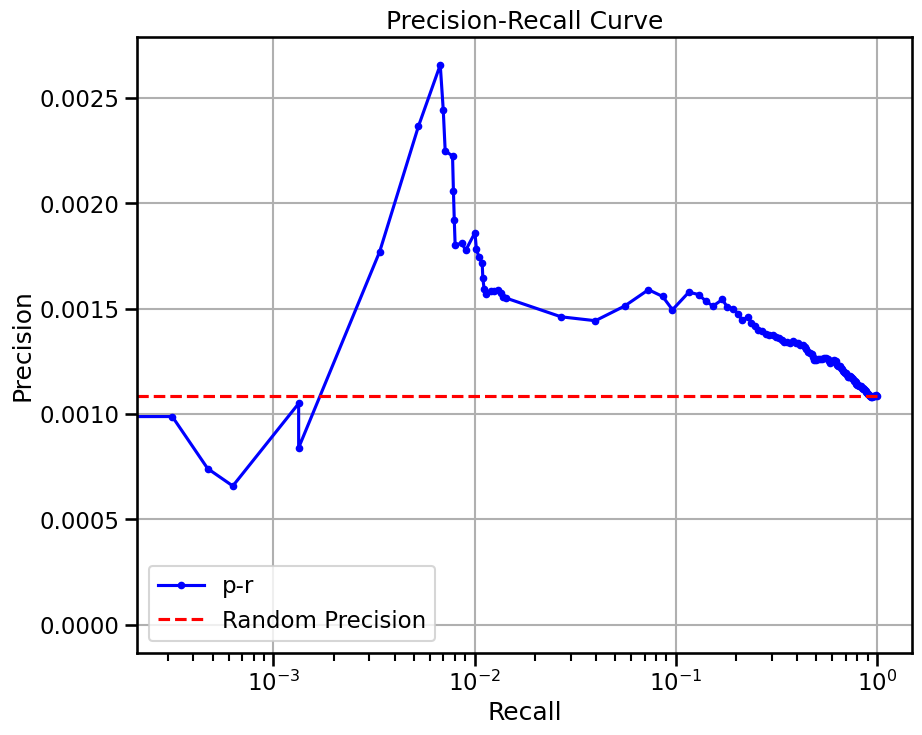

base enrichment
Top central genes: []


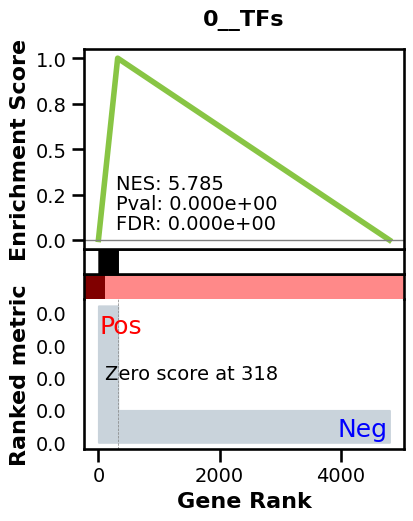

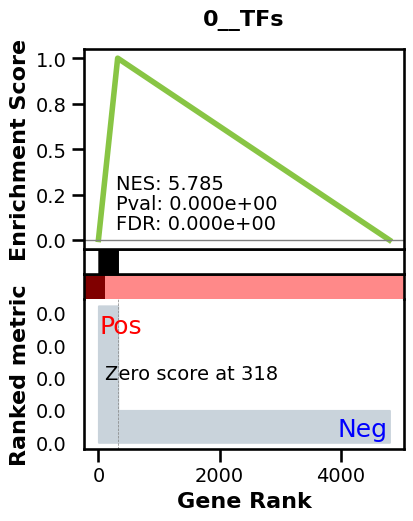

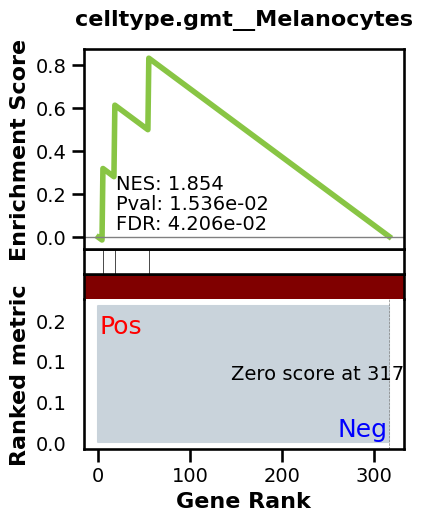

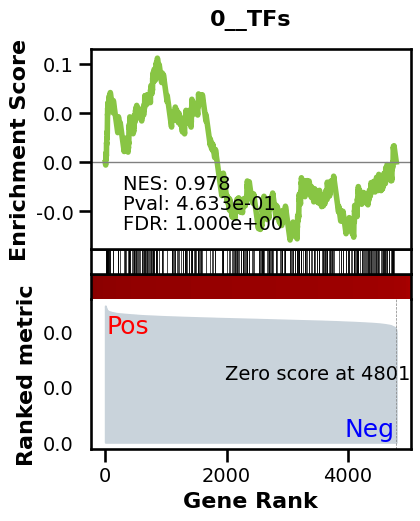

_________________________________________
TF specific enrichment
found some significant results for  6.451612903225806 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3426 genes
intersection pct: 0.7134527280299875
precision:  0.004692033382090251 
recall:  0.3368652382073621 
random precision: 0.001085814360770578


100%|██████████| 128/128 [00:02<00:00, 54.90it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0025375680778605626
EPR: 5.991311179042488


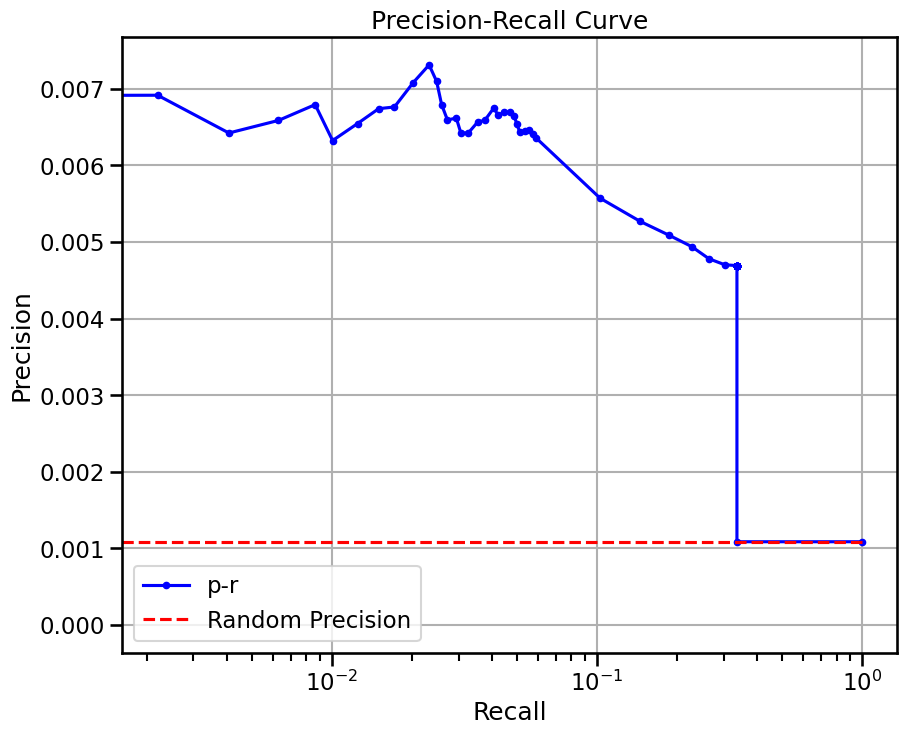

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


base enrichment
Top central genes: []


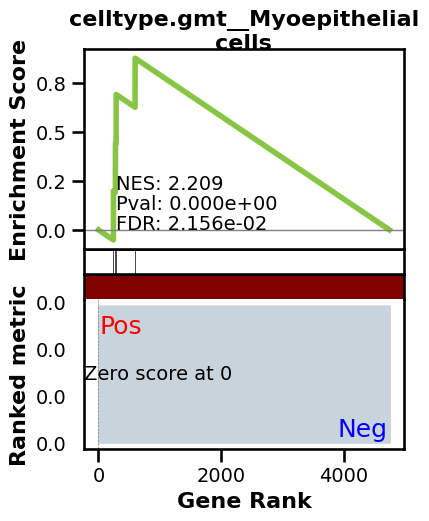

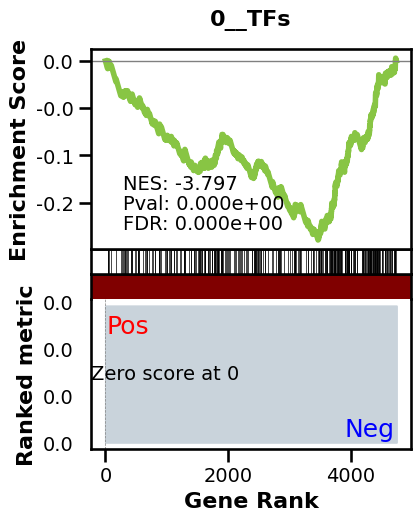

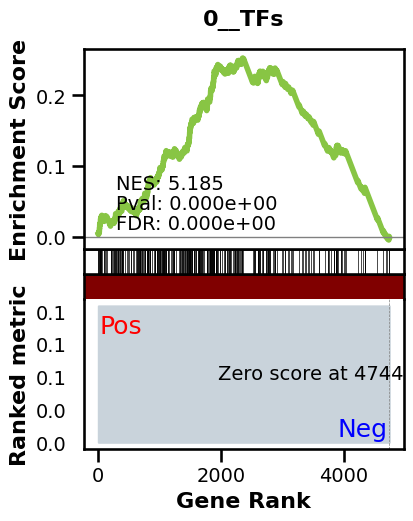

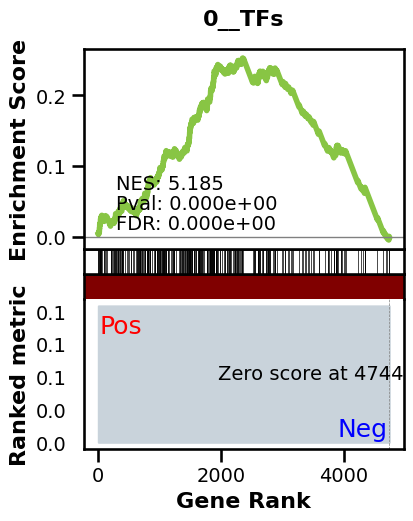

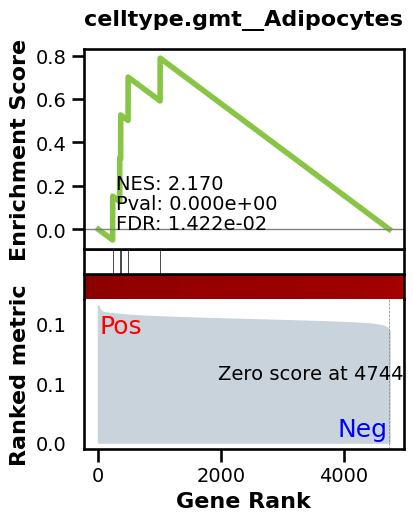

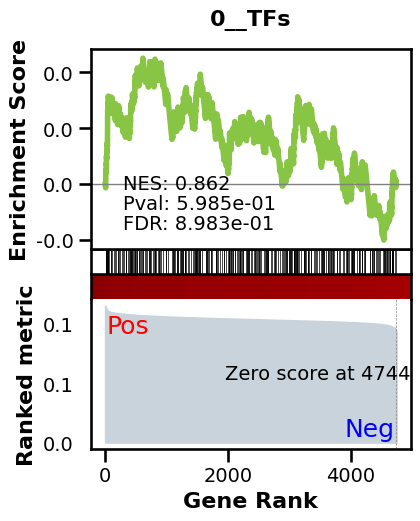

_________________________________________
TF specific enrichment
found some significant results for  17.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3339 genes
intersection pct: 0.7036880927291886
precision:  0.0012105207311093153 
recall:  1.0 
random precision: 0.0012108833796207323


100%|██████████| 128/128 [00:02<00:00, 58.65it/s]


Area Under Precision-Recall Curve (AUPRC):  0.001461192936113579
EPR: 0.5501256083253464


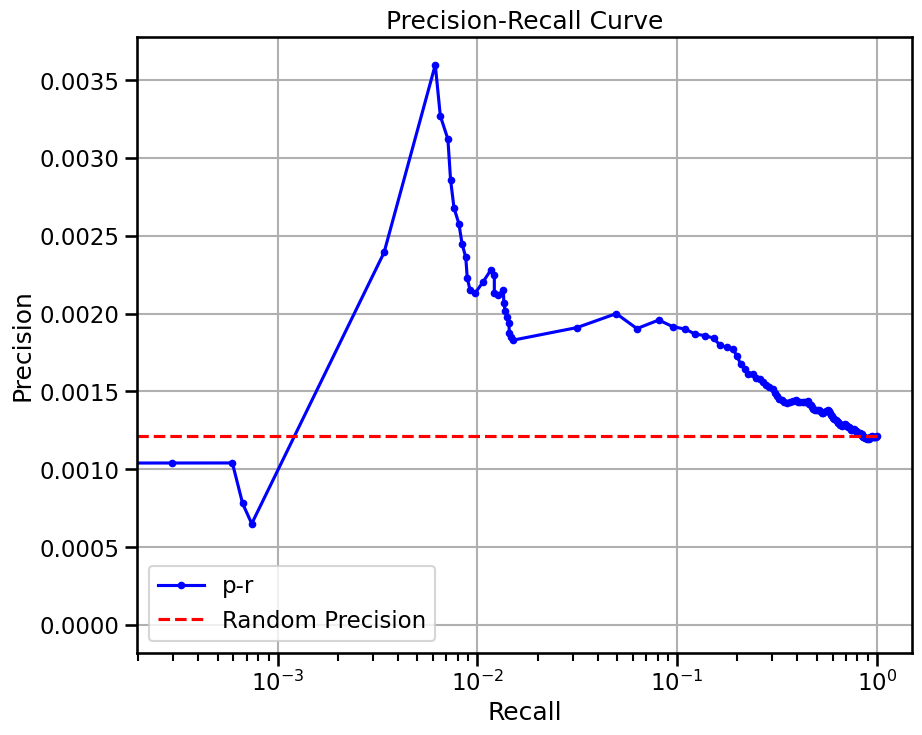

base enrichment
Top central genes: []


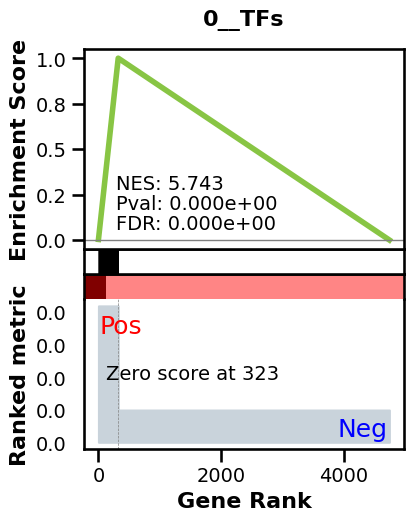

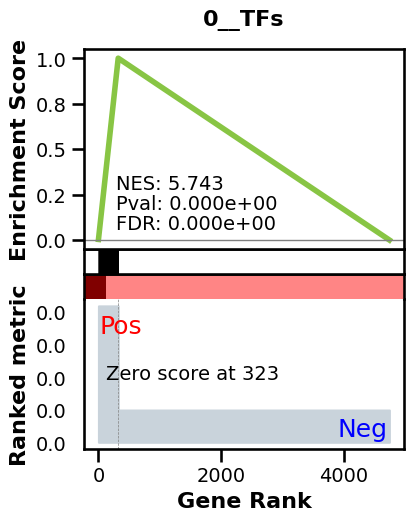

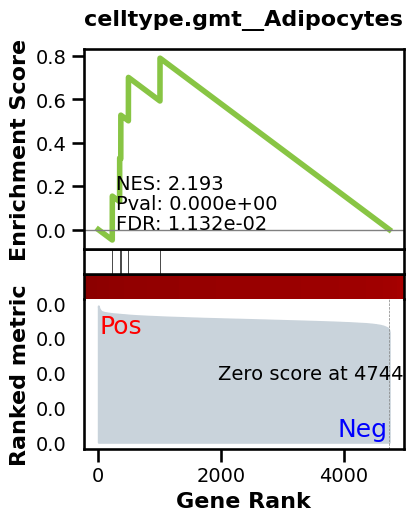

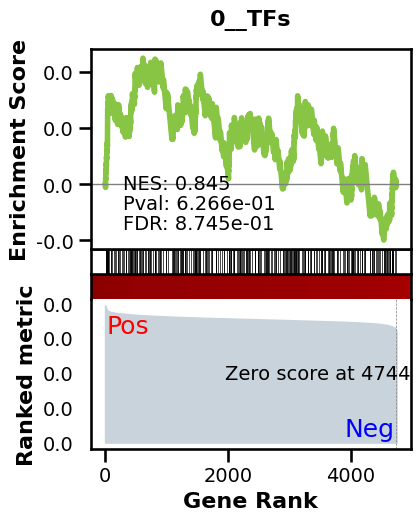

_________________________________________
TF specific enrichment
found some significant results for  5.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3339 genes
intersection pct: 0.7036880927291886
precision:  0.005939365444336027 
recall:  0.40997332542975695 
random precision: 0.0012108833796207323


100%|██████████| 128/128 [00:02<00:00, 58.06it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0034732750179841997
EPR: 6.762603805333789


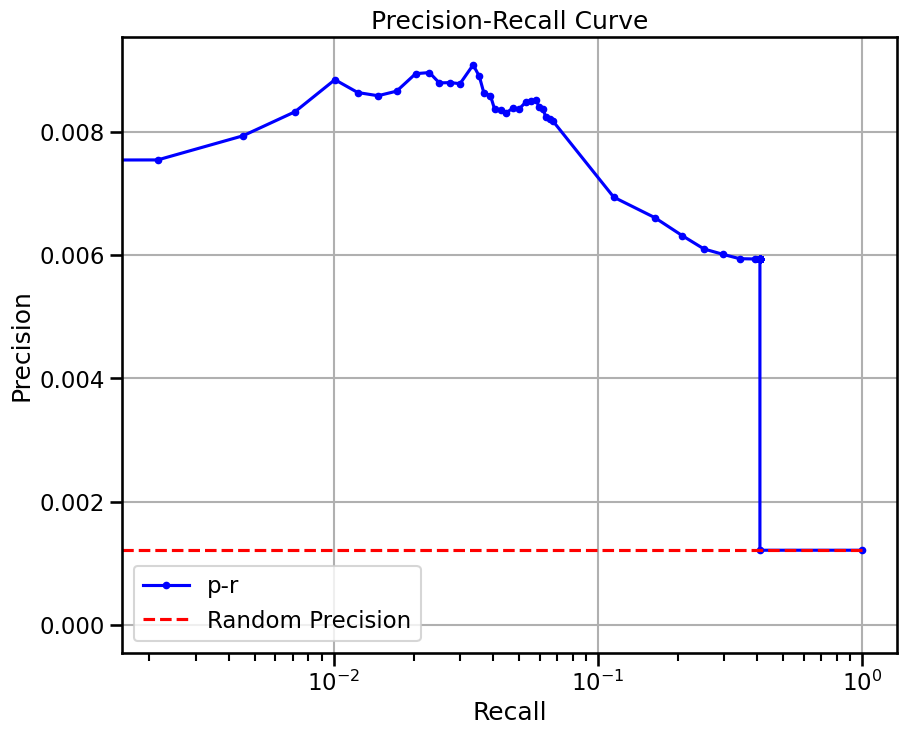

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 35/35 [00:30<00:00,  1.17it/s]


base enrichment
Top central genes: []


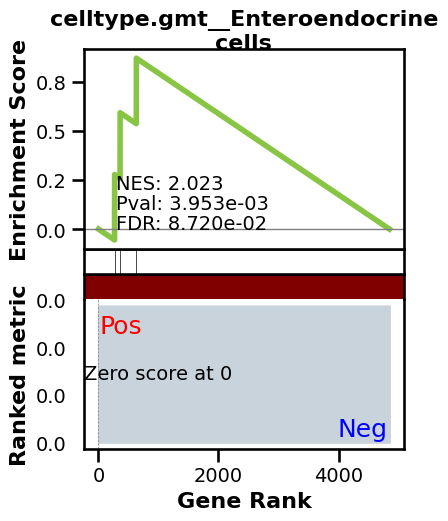

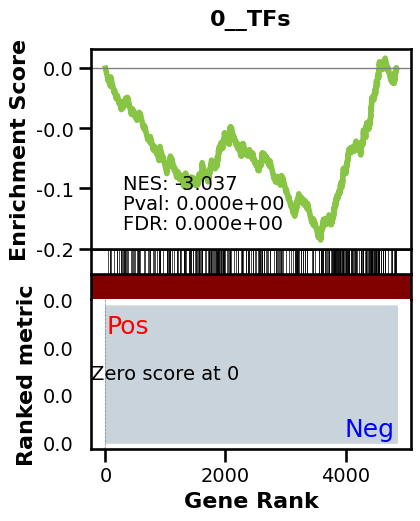

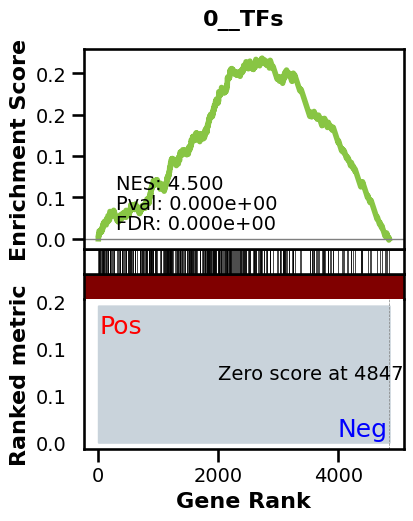

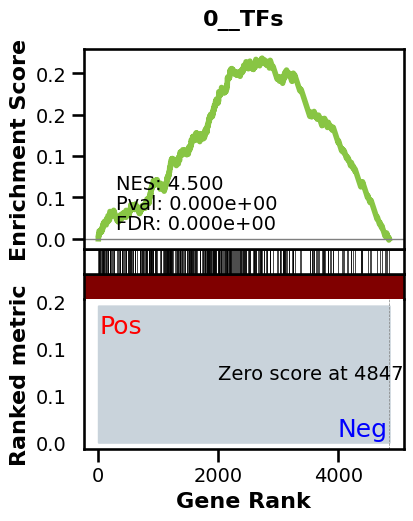

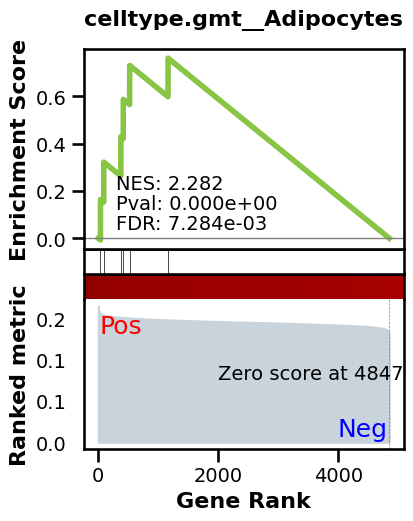

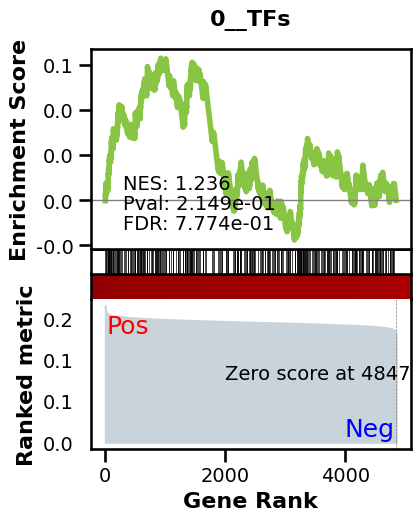

_________________________________________
TF specific enrichment
found some significant results for  18.571428571428573 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3500 genes
intersection pct: 0.721947194719472
precision:  0.0013918367346938776 
recall:  1.0 
random precision: 0.0013922345159841588


100%|██████████| 128/128 [00:02<00:00, 52.62it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0017273818995704863
EPR: 4.035825833835483


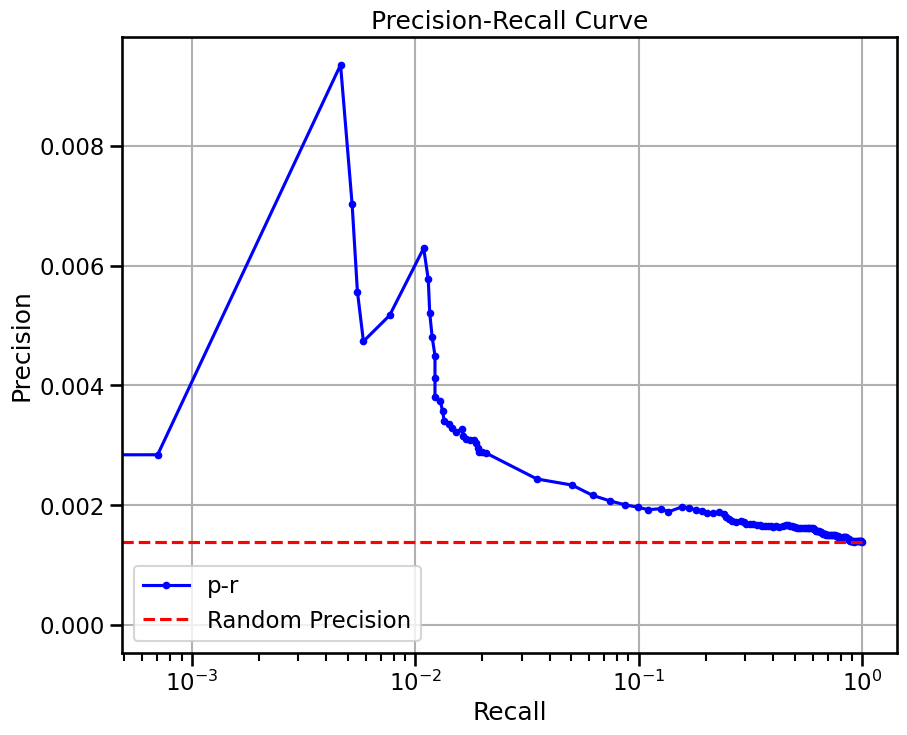

base enrichment
Top central genes: []


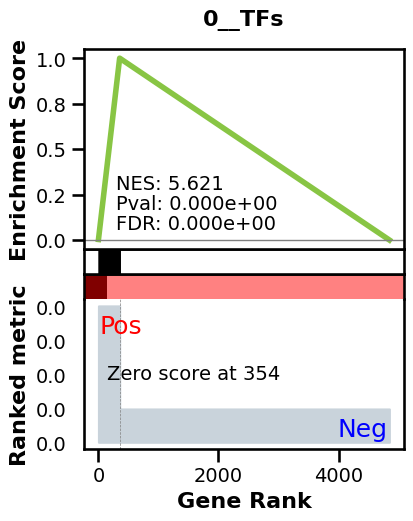

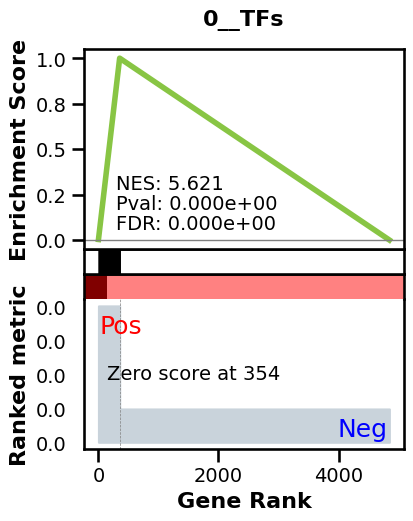

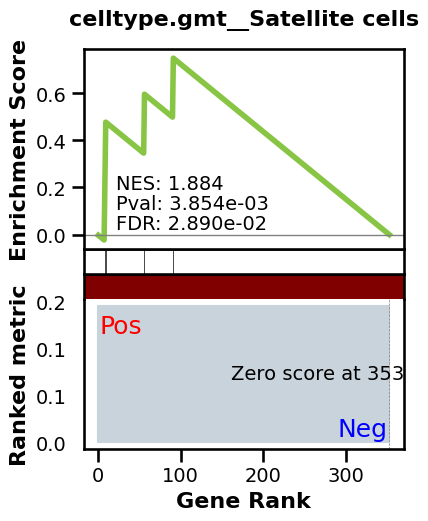

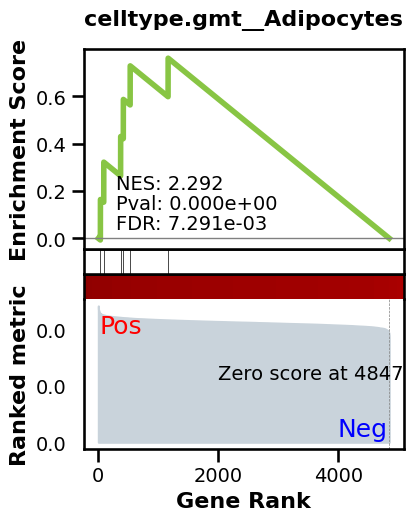

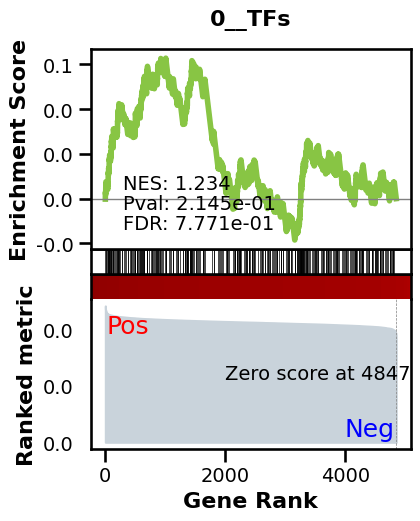

_________________________________________
TF specific enrichment
found some significant results for  1.4285714285714286 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3500 genes
intersection pct: 0.721947194719472
precision:  0.0071138173302107725 
recall:  0.4453958944281525 
random precision: 0.0013922345159841588


100%|██████████| 128/128 [00:02<00:00, 52.97it/s]


Area Under Precision-Recall Curve (AUPRC):  0.004610953167292602
EPR: 9.087792147244878


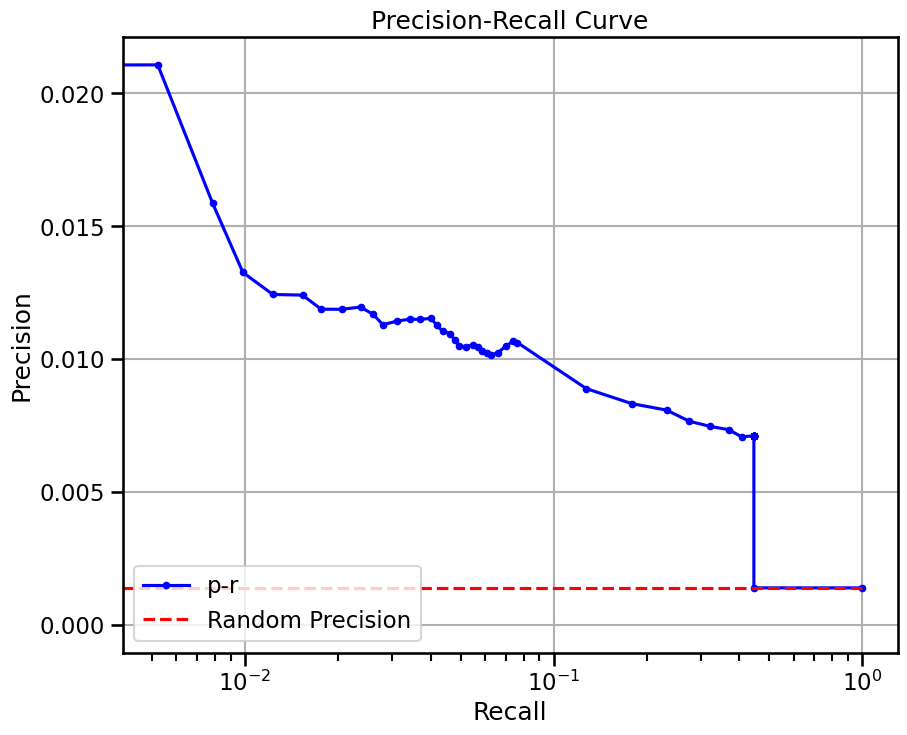

TypeError: __contains__(): incompatible function arguments. The following argument types are supported:
    1. (self: torchtext._torchtext.Vocab, arg0: str) -> bool

Invoked with: <torchtext._torchtext.Vocab object at 0x7f28bd808bb0>, nan

In [10]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(
        genes) & adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()

blood vessel smooth muscle cell
scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 22/22 [00:13<00:00,  1.63it/s]


base enrichment
Top central genes: []


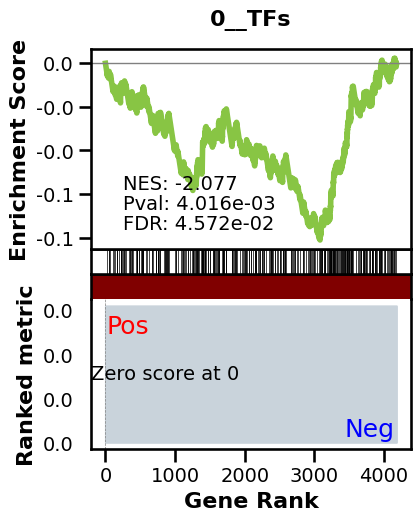

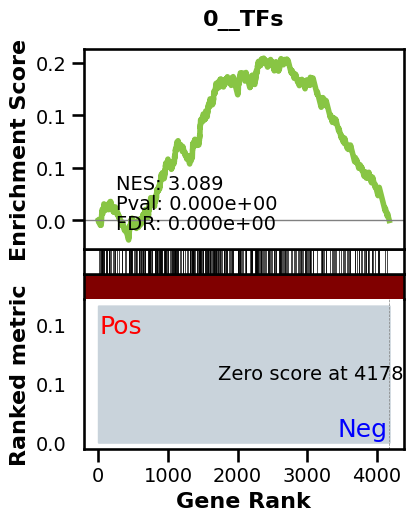

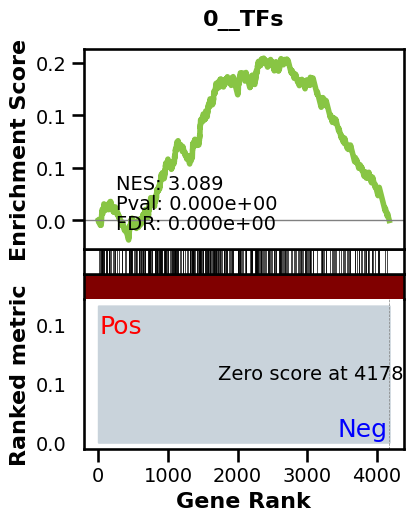

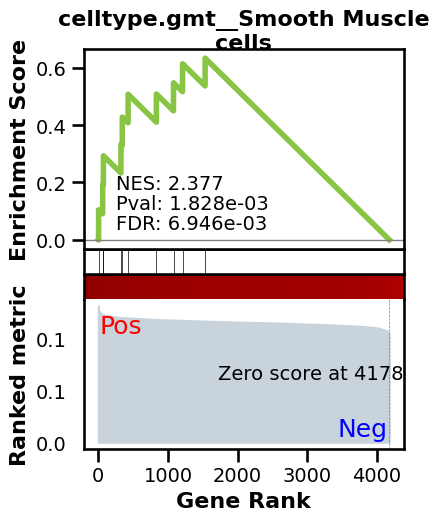

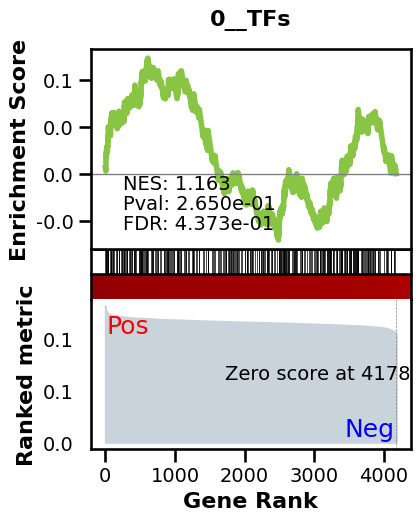

_________________________________________
TF specific enrichment
found some significant results for  13.20754716981132 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3065 genes
intersection pct: 0.7334290500119646
precision:  0.0016780522076062687 
recall:  1.0 
random precision: 0.0016785998747758531


100%|██████████| 128/128 [00:01<00:00, 67.97it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0020388513897513167
EPR: 3.1208545736059077


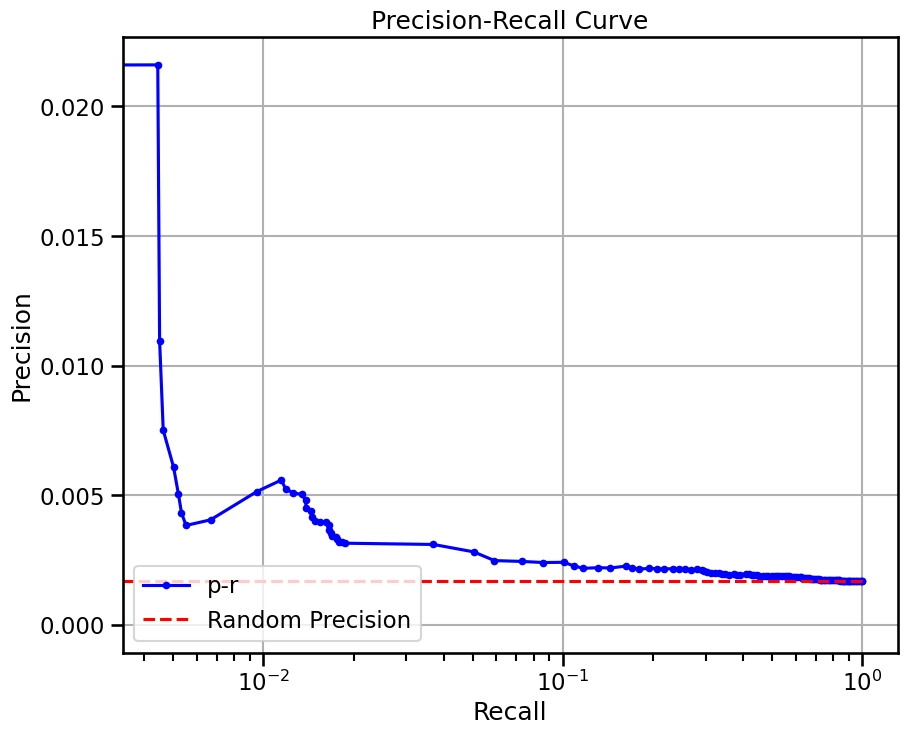

base enrichment
Top central genes: []


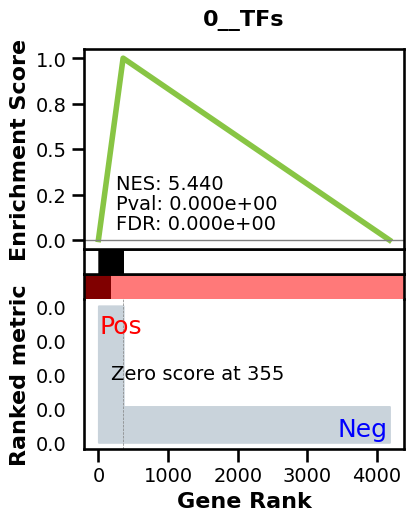

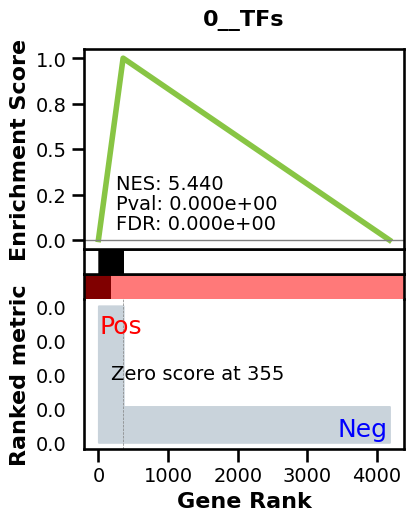

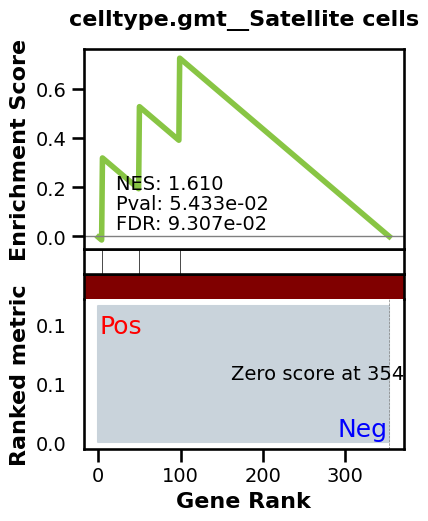

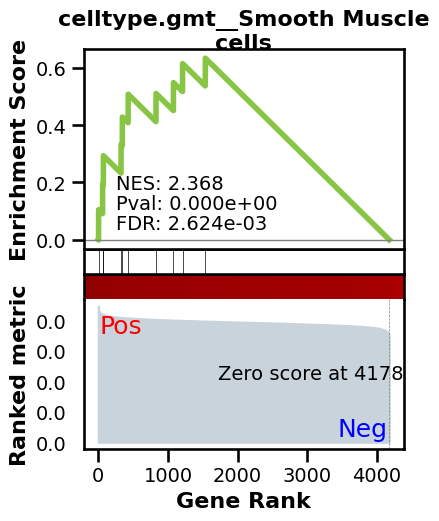

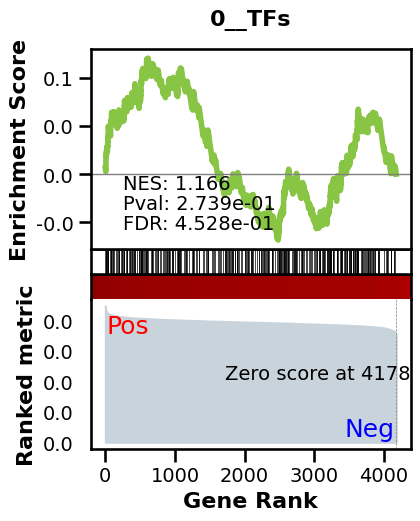

_________________________________________
TF specific enrichment

TF specific enrichment
found some significant results for  1.8867924528301887 % TFs

_________________________________________
loading GT,  omnipath


In [12]:
for celltype in CELLTYPES[4:]:
    print(celltype)
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(
        genes) & adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()

In [ ]:
metrics

In [ ]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df